### CNN 네트워크 

"Convolution - ReLU - Pooling - Affine - ReLU - Affine - Sofrmax" 순으로 흐름


##### • 초기화 때 받는 인수

• input_dim : 입력 데이터(채널 수, 높이, 너비)의 차원    

• conv_param : 합성곱 계층의 하이퍼파라미터(딕셔너리). 딕셔너리의 키는 다음과 같다.
    
     filter_num : 필터 수 
    
     filter_size : 필터의 크기
    
     stride : 스트라이드
    
     pad : 패딩

•hidden_size : 은닉층(완전연결)의 뉴런 수 

•output_size : 출력층(완전연결)의 뉴런 수 

•weigth_init_std : 초기화 때의 가중치 표준편차

In [6]:
import sys, os
sys.path.append("/Users/krc/Downloads/deep-learning-from-scratch-master")  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 매개변수 초기화하는 부분
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 학습에 필요한 매개변수는 1번째 층의 합성곱 계층과 두 완전연결 계층의 가중치와 편향        

        # CNN 구성하는 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

# 순서가 있는 딕셔너리인 layers에 계층들을 차례로 추가한다. 
# 마지막 softmaxwithloss는 last_layer라는 별도 변수에 저장 
# 이상이 SimpleConvNet의 초기화 

In [7]:
# 초기화 마치고 추론 수행하는 predict 메서드와 손실 함수 값 구하는 loss 메서드 구현
# 인수 x는 입력 데이터, t는 정답 레이블
# 추론 수행하는 predict 메서드는 초기화 때 layers에 추가한 계층 맨 앞부터 차례로 forward 메서드 호출하며 다음 계층에 전달. 
# 손실 함수 구하는 loss 메서드는 predict 메서드 결과를 인수로 마지막 층의 forward 메서드를 호출한다. 
# 즉, 첫 계층부터 마지막 계층까지 forward를 처리한다.

def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)


In [8]:
# 오차역전파법으로 기울기 구하기 
# 매개변수의 기울기는 오차역전파법으로 구한다. 순전파와 역전파 반복

def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

# grads라는 딕셔너리 변수에 각 가중치 매개변수의 기울기를 저장한다. 
# 이상이 SimpleConvNet 구현 


train loss:2.2996503053802866
=== epoch:1, train acc:0.212, test acc:0.191 ===
train loss:2.299052676840693
train loss:2.29516774271261
train loss:2.290626531417012
train loss:2.2844686740519373
train loss:2.277413789990815
train loss:2.2604208803339243
train loss:2.2480716341101874
train loss:2.22728417192762
train loss:2.218667540108635
train loss:2.1781265850293066
train loss:2.157468672433832
train loss:2.1095974083067657
train loss:2.0300300918619505
train loss:2.0377314574444085
train loss:1.9384866899674376
train loss:1.9082044362899202
train loss:1.8303643412988972
train loss:1.779375702338008
train loss:1.7143215749170266
train loss:1.7147483913462285
train loss:1.6220293164292312
train loss:1.506146451632491
train loss:1.4525620327974265
train loss:1.2911792959391528
train loss:1.2125542816003902
train loss:1.200948965541546
train loss:0.9730151650553113
train loss:1.0746661860562716
train loss:0.9868275550424876
train loss:0.9769216087056464
train loss:0.9368400340822863
tra

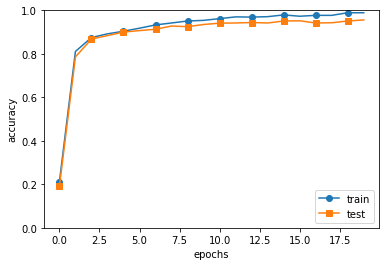

In [11]:
# SimpleConvNet을 MNIST 데이터셋으로 학습

import sys, os
sys.path.append("/Users/krc/Downloads/deep-learning-from-scratch-master/ch07")  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

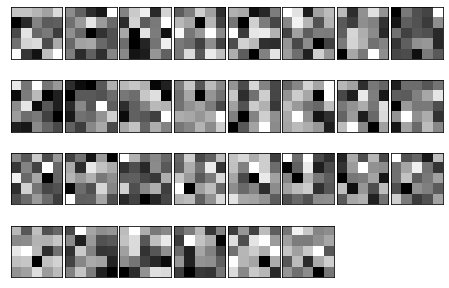

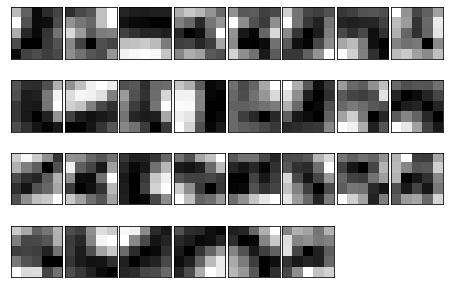

In [12]:
# CNN 시각화 하기 

import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

# 위와 같이 학습 전 필터는 무작위로 초기화 되어 흑백 정도에 규칙성이 없다. 
# 학습 마친 필터는 규칙성 있는 이미지가 되었다. 
# 흰색에서 검은색으로 점차 변화하는 필터와 덩어리(블롭)가 진 필터 등, 규칙을 띄는 필터로 바뀜

• 딥러닝 흥미로운 점 

: 합성곱 계층을 여러 겹 쌓으면, 층이 깊어지면서 더 복잡하고 추상화된 정보가 추출된다. 
####
→ 처음 층은 단순한 에지에 반응, 이어 텍스처에 반응, 더 복잡한 사물의 일부에 반응하도록 변화 
####
▶︎ 즉, 층이 깊어지면서 뉴런이 반응하는 대상이 단순한 모양에서 '고급' 정보로 변화해간다. 

### • 대표적인 CNN

#### 1. LeNet

: 손글씨 숫자를 인식하는 네트워크 

→ 활성화 함수 / 주로 ReLU 사용 / 최대 풀링이 주류 

▶︎ 시그모이드를 사용하는 데 반해, ReLU로 사용하고 서브샘플링 해서 중간 데이터 크기 줄이는데 현재 최대 풀링 이용하는 것


#### 2. AlexNet 

: 합성곱 계층과 풀링 계층을 거듭하며 마지막으로 완전연결 계층을 거쳐 결과를 출력 

→ 활성화 함수로 ReLU 사용 / LRN이라는 국소적 정규화 실시하는 계층 이용 / 드롭아웃 사용

### 8장 정리

#### • CNN 

- 지금까지 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층 새로 추가한다.

- 합성곱 계층과 풀링 계층은 im2col(이미지 행렬로 전개하는 함수) 이용하면 간단하고 효율적으로 구현 

- CNN 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습 확인

- LeNet, AlexNet이 있다.

- 딥러닝 발전에는 빅데이터와 GPU가 크게 기여했다. 